# 1. Introduction



In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_auc_score, brier_score_loss, RocCurveDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibrationDisplay



data = pd.read_csv('/Users/hungduong/Documents/MSBA UofU/MSBA 4th/MKTG 6620/churn_train.csv')

### Business Problem

### Leakage Policy

### Data overview and EDA

In [131]:
# Data highview
pd.set_option('display.max_columns', None)
data.head()

,ID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,yrhdgfy_4741,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,yrhdgfy_4154,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,yrhdgfy_5863,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,yrhdgfy_4870,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,yrhdgfy_4813,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


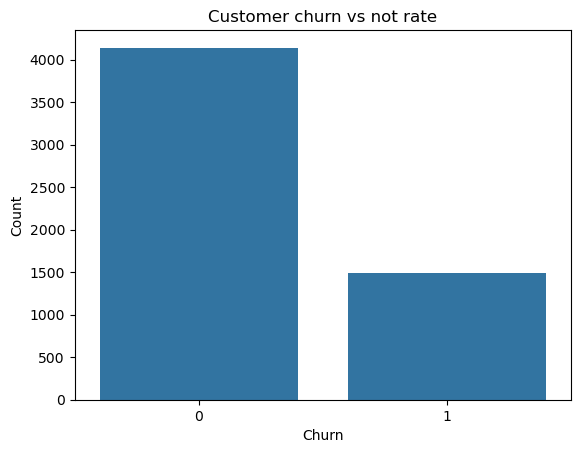

Churn rate is 26.54%


In [132]:
# Looks at Target variable
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

sns.countplot(x='Churn', data=data)
plt.title('Customer churn vs not rate')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

#Target rate is imbalance
print(f"Churn rate is {data['Churn'].mean() * 100:.2f}%")


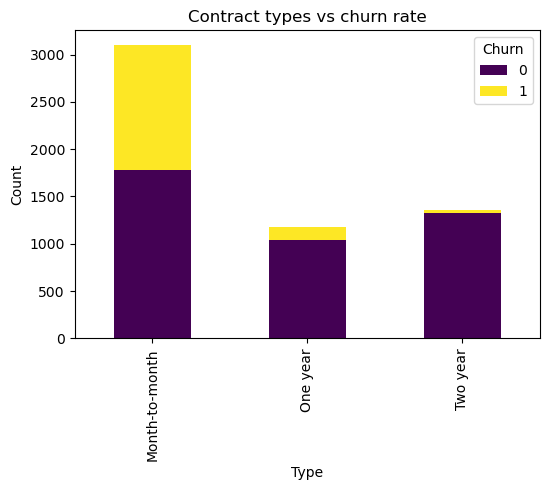

In [133]:
# How do contract type correlate with Churn?
pd.crosstab(data['Contract'], data['Churn']).plot(
    kind='bar',
    stacked=True,
    figsize=(6,4),
    colormap='viridis'
)

plt.title('Contract types vs churn rate')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

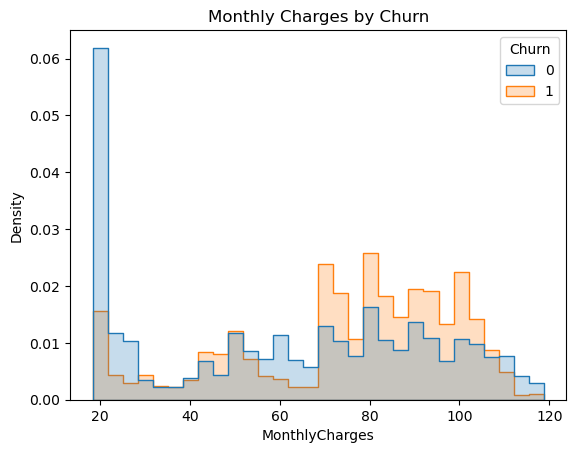

In [134]:
# How do monthly charges influence Churn?
sns.histplot(data=data, x='MonthlyCharges', hue='Churn',
             bins=30, stat='density', common_norm=False, element='step')
plt.title('Monthly Charges by Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.show()

This plot is showing that people with low monthly charges tends not to churn, around $20-$40.


However, the group that churn the most seems to be high monthly charges ones noticeably around $70-$110.

# 2. Machine Learning

### Data preparation


In [135]:
# Prepare data for ML
data_ml = data.copy()

# get dummies variable
data_ml = pd.get_dummies(
    data_ml,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True  #
)

# Fix total charges dtype
data_ml['TotalCharges'] = pd.to_numeric(data_ml['TotalCharges'], errors='coerce').fillna(0)

# Check dtype
data_ml.dtypes

ID                                        object
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
gender_Male                                 bool
SeniorCitizen_1                             bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

In [136]:
# Split data 
x = data_ml.drop(columns=['Churn', 'ID']) 
y = data_ml['Churn'] 
cv = StratifiedKFold(5, shuffle=True, random_state=111)

### Simple baseline Logistic Model

In [137]:
# Logistic model with penalty Lasso Ridge
log_pipe = Pipeline(
    [("scaler", StandardScaler()), 
     ("logreg", LogisticRegression(penalty='elasticnet', C=1.0, 
                                   solver='saga', l1_ratio=0.5, 
                                   max_iter=1000, 
                                   class_weight='balanced' # handle class imbalance
                                   ))])

log_model_scores = cross_validate(
    log_pipe, x, y, 
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False )



In [138]:
# Result 
print(pd.DataFrame(log_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
log_model_prob = cross_val_predict(log_pipe, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, log_model_prob) 
brier_oof = brier_score_loss(y, log_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 


# Feature importance 
log_pipe.fit(x, y) 
coef_table = pd.DataFrame({ "Feature": x.columns, "Coefficient": log_pipe.named_steps["logreg"].coef_.flatten() }) 
pd.set_option('display.max_rows', None) 
print(coef_table)

test_roc    0.845
test_acc    0.750
test_f1     0.629
dtype: float64
Discrimination AUC: 0.845
Calibration Brier: 0.1653
                                  Feature  Coefficient
0                                  tenure    -1.150568
1                          MonthlyCharges    -0.827831
2                            TotalCharges     0.483840
3                             gender_Male     0.015588
4                         SeniorCitizen_1     0.056214
5                             Partner_Yes     0.007984
6                          Dependents_Yes    -0.103980
7                        PhoneService_Yes     0.003061
8          MultipleLines_No phone service    -0.003061
9                       MultipleLines_Yes     0.184331
10            InternetService_Fiber optic     0.725018
11                     InternetService_No    -0.088432
12     OnlineSecurity_No internet service    -0.088432
13                     OnlineSecurity_Yes    -0.129362
14       OnlineBackup_No internet service    -0.088432

### Random Forest

In [139]:
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=10,        
    random_state=42,       
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1              
)

rf_model_scores = cross_validate(
    rf_model, x, y,
    cv=cv, 
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'}, 
    return_train_score=False
)

In [140]:
# Result 
print(pd.DataFrame(rf_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Discrimination - AUC and Brier Score 
rf_model_prob = cross_val_predict(rf_model, x, y, cv=cv, method='predict_proba')[:, 1] 
auc_oof = roc_auc_score(y, rf_model_prob) 
brier_oof = brier_score_loss(y, rf_model_prob, pos_label=1) 

print(f"Discrimination AUC: {auc_oof:.3f}") 
print(f"Calibration Brier: {brier_oof:.4f}") 

test_roc    0.844
test_acc    0.781
test_f1     0.634
dtype: float64
Discrimination AUC: 0.844
Calibration Brier: 0.1478


### Gradient Boosting Tree

In [141]:
# Train and c
gbt_model = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=800,
    max_depth=3,
    subsample=1.0,
    max_features='log2',
    random_state=42
)

gbt_score = cross_validate( 
    gbt_model, x, y, cv=cv, 
    scoring={'roc':'roc_auc', 'acc':'accuracy', 'f1':'f1'}, 
    return_train_score=True )

In [142]:
# Result from CV
print(pd.DataFrame(gbt_score)[['test_roc','test_acc','test_f1']].mean().round(3)) 

# Get Out of fold results
oof_proba = cross_val_predict(
    gbt_model, x, y, cv=cv, method='predict_proba'
)[:, 1]

# Metrics on OOF probs
auc_oof   = roc_auc_score(y, oof_proba)          # discrimination AUC
brier_oof = brier_score_loss(y, oof_proba)       # calibration 

print(f"OOF ROC-AUC: {auc_oof:.3f}")
print(f"OOF Brier : {brier_oof:.4f}")

test_roc    0.850
test_acc    0.807
test_f1     0.592
dtype: float64
OOF ROC-AUC: 0.849
OOF Brier : 0.1333


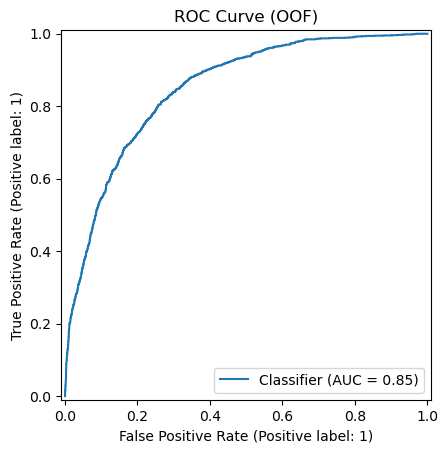

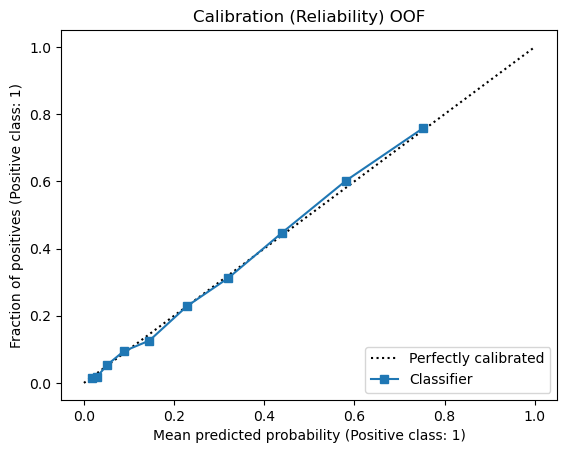

In [143]:
# Plots out of fold ROC
RocCurveDisplay.from_predictions(y, oof_proba)
plt.title("ROC Curve (OOF)"); plt.show()

# Plot out of fold calibration
CalibrationDisplay.from_predictions(y, oof_proba, n_bins=10, strategy='quantile')
plt.title("Calibration (Reliability) OOF"); plt.show()

### Ablation Table

In [152]:


# --- Full model metrics
oof_full = cross_val_predict(gbt_model, x, y, cv=cv, method='predict_proba')[:, 1]
auc_full, brier_full = roc_auc_score(y, oof_full), brier_score_loss(y, oof_full)

# --- Groups
groups = {
    "Demographics": [
        "gender_Male", "SeniorCitizen_1", "Partner_Yes", "Dependents_Yes"
    ],
    "Core_Access": [
        "PhoneService_Yes", "MultipleLines_No phone service", "MultipleLines_Yes",
        "InternetService_Fiber optic", "InternetService_No"
    ],
    "AddOns_Streaming": [
        "OnlineSecurity_No internet service", "OnlineSecurity_Yes",
        "OnlineBackup_No internet service", "OnlineBackup_Yes",
        "DeviceProtection_No internet service", "DeviceProtection_Yes",
        "TechSupport_No internet service", "TechSupport_Yes",
        "StreamingTV_No internet service", "StreamingTV_Yes",
        "StreamingMovies_No internet service", "StreamingMovies_Yes"
    ],
    "Contracts_Billing": [
        "Contract_One year", "Contract_Two year", "PaperlessBilling_Yes",
        "PaymentMethod_Credit card (automatic)",
        "PaymentMethod_Electronic check", "PaymentMethod_Mailed check",
        "MonthlyCharges", "TotalCharges"
    ]
}


rows = []
for name, cols in groups.items():
    X_drop = x.drop(columns=cols, errors="ignore")
    oof_proba = cross_val_predict(gbt_model, X_drop, y, cv=cv, method='predict_proba')[:, 1]
    oof_pred = (oof_proba >= 0.5).astype(int)  # threshold = 0.5
    
    auc = roc_auc_score(y, oof_proba)
    brier = brier_score_loss(y, oof_proba)
    acc = accuracy_score(y, oof_pred)
    
    rows.append([name, auc, brier, acc])

# --- Full model metrics
oof_full = cross_val_predict(gbt_model, x, y, cv=cv, method='predict_proba')[:, 1]
oof_pred_full = (oof_full >= 0.5).astype(int)
auc_full = roc_auc_score(y, oof_full)
brier_full = brier_score_loss(y, oof_full)
acc_full = accuracy_score(y, oof_pred_full)

# --- Make table
ablation = pd.DataFrame(rows, columns=["Removed_Group","AUC","Brier","Accuracy"])
ablation["Delta AUC"] = ablation["AUC"] - auc_full            # AUC no group vs full model 
ablation["Delta Brier"] = ablation["Brier"] - brier_full
ablation["Delta Accuracy"] = ablation["Accuracy"] - acc_full

full = pd.DataFrame(
    [["Full Model", auc_full, brier_full, acc_full, 0, 0, 0]],
    columns=ablation.columns
)
ablation_table = pd.concat([full, ablation], ignore_index=True)

print(ablation_table.round(4))

       Removed_Group     AUC   Brier  Accuracy  Delta AUC  Delta Brier  \
0         Full Model  0.8492  0.1333    0.8071     0.0000       0.0000   
1       Demographics  0.8489  0.1334    0.8064    -0.0003       0.0002   
2        Core_Access  0.8475  0.1343    0.8021    -0.0018       0.0010   
3   AddOns_Streaming  0.8457  0.1347    0.8024    -0.0036       0.0014   
4  Contracts_Billing  0.8373  0.1373    0.7968    -0.0120       0.0040   

   Delta Accuracy  
0          0.0000  
1         -0.0007  
2         -0.0050  
3         -0.0046  
4         -0.0103  


There is no increase in AUC score if exclude any of the predictor groups; in other words, every group contribute positively to the prediction process.

The most important groups are - in order: 
* Personal Chracteristics: Due to largest drop in Delta (-0.0184), Delta Brier (0.086), Delta Accuracy (-0.0149)
* Contracts
* Customer Services ()

In [145]:
data_ml.head()

,ID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,yrhdgfy_4741,35,49.20,1701.65,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False
1,yrhdgfy_4154,15,75.10,1151.55,0,True,False,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,yrhdgfy_5863,13,40.55,590.35,0,True,False,True,True,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True
3,yrhdgfy_4870,26,73.50,1905.70,0,False,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,True,True,True,False,False
4,yrhdgfy_4813,1,44.55,44.55,0,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
